In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

### Geometric Brownian Motion
$$S_t = S_0 e^{(\mu - \frac{\sigma^2}{2})t + \sigma \sqrt{t} \mathcal{N}(0,1)}$$

In [2]:
def simulate_gbm(S0, mu, sigma_real, T, N, seed=None):
    """ Simulate geomtric brownian motion
    """
    if seed is not None:
        np.random.seed(seed)
    dt = T / N
    S = np.zeros(N + 1)
    S[0] = S0

    for i in range(N):
        Z = np.random.randn()
        S[i + 1] = S[i] * np.exp(
            (mu - 0.5 * sigma_real**2) * dt + sigma_real * np.sqrt(dt) * Z
        )
    
    return S.tolist()  


### Black-Scholes Call and Put price/delta
$$
\begin{aligned}
C &= S_0\,\Phi(d_1) - K e^{-rT}\,\Phi(d_2),\\[6pt]
P &= K e^{-rT}\,\Phi(-d_2) - S_0\,\Phi(-d_1),
\end{aligned}
$$

$$
\text{With}\quad
d_1 = \dfrac{\ln\!\big(\tfrac{S_0}{K}\big) + \big(r + \tfrac{\sigma^2}{2}\big)T}{\sigma\sqrt{T}},\qquad
d_2 = d_1 - \sigma\sqrt{T}.
$$

$$
\Delta_{\text{call}} = \Phi(d_1),\qquad
\Delta_{\text{put}} = \Phi(d_1) - 1.
$$


In [3]:
def black_scholes_call_price(S, K, T, r, sigma):
    if T <= 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2)* T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def black_scholes_put_price(S, K, T, r, sigma):
    if T <= 0:
        return max(K - S, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

def black_scholes_call_delta(S, K, T, r, sigma):
    if T <= 0:
        return 1.0 if S > K else 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def black_scholes_put_delta(S, K, T, r, sigma):
    if T <= 0:
        return -1.0 if S < K else 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1) - 1 

# Part 1 : Let's try to simulate gamma scalping for a long **call**

In the following scripts, we simulate a path of a geometric Brownian motion with a realized volatility sigma_real given as a parameter.
We assume we are long a call option with 5 days to maturity, priced using an implied volatility sigma_iv, also provided as a parameter.
This call option is delta-hedged every day.
At the end, we compute the total PnL of the strategy, which should theoretically depend on the difference between the realized volatility and the implied volatility.

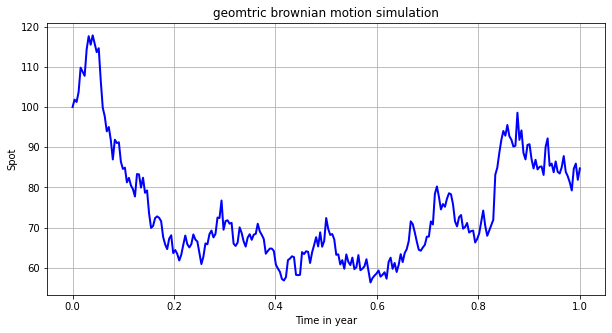

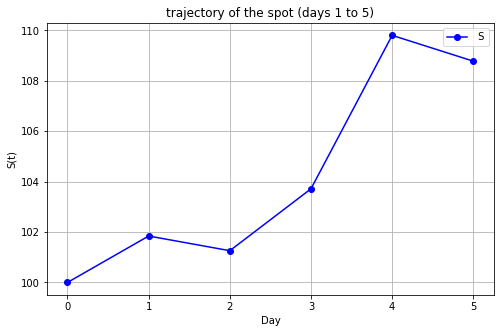

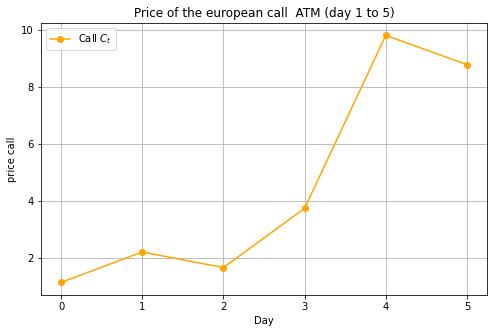

In [4]:
S0 = 100
mu = 0.05
sigma_real = 0.6 # PARAMETER TO SET
T = 1.0
N = 252

r = 0.01
K = S0 
sigma_iv = 0.2 # PARAMETER TO SET


# ----------------- trajectory of St -------------------- #
trajectory = simulate_gbm(S0, mu, sigma_real, T, N, seed=42)

# Grille de temps
t = np.linspace(0, T, N + 1)

# Graphique
plt.figure(figsize=(10, 5))
plt.plot(t, trajectory, lw=2, color='blue')
plt.title("geomtric brownian motion simulation")
plt.xlabel("Time in year")
plt.ylabel("Spot")
plt.grid(True)
plt.show()

# ---------------- trajectory of St on 5days ----------------- #

jours = np.arange(0, 6)  # Jours 1 à 5
S_values = [trajectory[j] for j in jours]  # Valeurs du sous-jacent sur ces jours

plt.figure(figsize=(8,5))
plt.plot(jours, S_values, marker='o', color='blue', label=" S")
plt.title("trajectory of the spot (days 1 to 5)")
plt.xlabel("Day")
plt.ylabel("S(t)")
plt.grid(True)
plt.legend()
plt.show()


# ----------------- trajectory of the call ------------------- #
jours = np.arange(0, 6)  
C = []
for j in jours:
    S_t = trajectory[j]                   
    time_to_maturity = (5 - j) / 252    
    C_t = black_scholes_call_price(S_t, K, time_to_maturity, r, sigma_iv)
    C.append(C_t)


plt.figure(figsize=(8,5))
plt.plot(jours, C, marker='o', color='orange', label="Call $C_t$")
plt.title("Price of the european call  ATM (day 1 to 5)")
plt.xlabel("Day")
plt.ylabel("price call")
plt.grid(True)
plt.legend()
plt.show()

what is gained in the delta hedge portfolio between t1 and t2 :  -0.9348505574466968
what we gain in the call between t1 and t2 :  1.0694123960522646
what is gained in the delta hedge portfolio between t1 and t2 :  0.4528246446365093
what we gain in the call between t1 and t2 :  -0.5485543587618338
what is gained in the delta hedge portfolio between t1 and t2 :  -1.7712943803714911
what we gain in the call between t1 and t2 :  2.08221909960686
what is gained in the delta hedge portfolio between t1 and t2 :  -5.9653323583271
what we gain in the call between t1 and t2 :  6.071563063290839
what is gained in the delta hedge portfolio between t1 and t2 :  1.0275989275819617
what we gain in the call between t1 and t2 :  -1.0275989275820336
[0.1345618386055678, 0.03883212448024331, 0.3497568437156122, 0.4559875486793512, 0.45598754867927926]


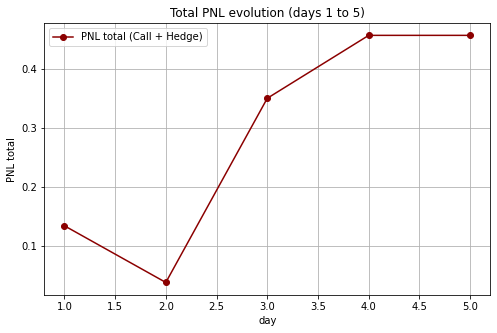

In [5]:
# --- Calculation and plotting of total PNL (Call + replication strategy) ---

jours = np.arange(1, 6)  
dt = 1/252
hedge_gain = []
PNL_total = []
C_0 = black_scholes_call_price(S0, K, 5/252, r, sigma_iv)

for j in jours:
    S_tbefore = trajectory[j-1]
    S_t = trajectory[j]
    time_to_maturity_before = (5 - (j-1)) / 252
    time_to_maturity = (5 - j)/ 252

    # Prix du call et delta
    C_tbefore = black_scholes_call_price(S_tbefore, K, time_to_maturity_before, r, sigma_iv)
    C_t = black_scholes_call_price(S_t, K, time_to_maturity, r, sigma_iv)

    delta_t = black_scholes_call_delta(S_tbefore, K, time_to_maturity_before, r, sigma_iv)

    # Stratégie de réplication (hedge)
    # t1 and t2 are two consecutive moments of delta hedging.
    hedge_value = -delta_t * (S_t-S_tbefore) + (delta_t * S_tbefore - C_tbefore) * (np.exp(r * dt)-1)
    print("what is gained in the delta hedge portfolio between t1 and t2 : ",hedge_value)
    print("what we gain in the call between t1 and t2 : ", C_t - C_tbefore)
    hedge_gain.append(hedge_value)

    # PNL total = Call + Hedge
    pnl_total_t = (C_t-C_0) + np.sum(hedge_gain[:j]) #Serie telescopique
    #print("diff de call : ", C_t-C_tbefore)
    PNL_total.append(pnl_total_t)
    
print(PNL_total)

# --- Tracé ---   
plt.figure(figsize=(8,5))
plt.plot(jours, PNL_total, marker='o', color='darkred', label="PNL total (Call + Hedge)")
plt.title("Total PNL evolution (days 1 to 5)")
plt.xlabel("day")
plt.ylabel("PNL total")
plt.grid(True)
plt.legend()
plt.show()


In [6]:
print("PNL total = ", PNL_total[-1])

PNL total =  0.45598754867927926


C =  2.203103820580452
C =  1.6545494618186183
C =  3.736768561425478
C =  9.808331624716317
C =  8.780732697134283


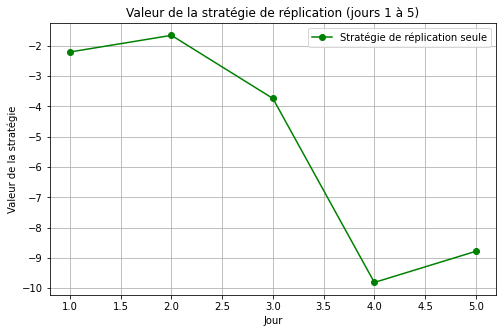

In [7]:
# --- Calcul et tracé de la trajectoire de la stratégie de réplication seule ---

jours = np.arange(1, 6)  # jours 1 à 5
dt = 1/252
replication_values = []

for j in jours:
    S_t = trajectory[j]
    time_to_maturity = (5 - j) / 252

    # Prix du call et delta à cet instant
    C_t = black_scholes_call_price(S_t, K, time_to_maturity, r, sigma_iv)
    print("C = ", C_t)
    delta_t = black_scholes_call_delta(S_t, K, time_to_maturity, r, sigma_iv)

    # Valeur de la stratégie de réplication (hedge)
    hedge_value = -delta_t * S_t + (delta_t * S_t - C_t) 
    replication_values.append(hedge_value)

# --- Tracé ---
plt.figure(figsize=(8,5))
plt.plot(jours, replication_values, marker='o', color='green', label="Stratégie de réplication seule")
plt.title("Valeur de la stratégie de réplication (jours 1 à 5)")
plt.xlabel("Jour")
plt.ylabel("Valeur de la stratégie")
plt.grid(True)
plt.legend()
plt.show()


# Part 2 : Let's try to simulate gamma scalping for a long **straddle**

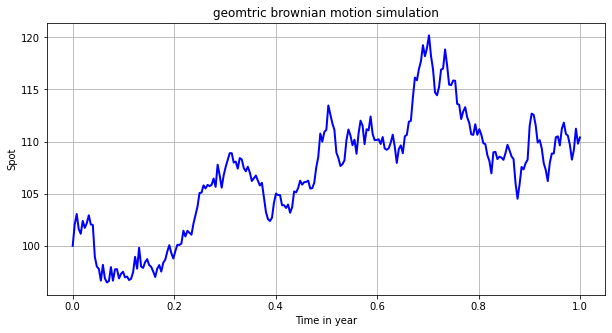

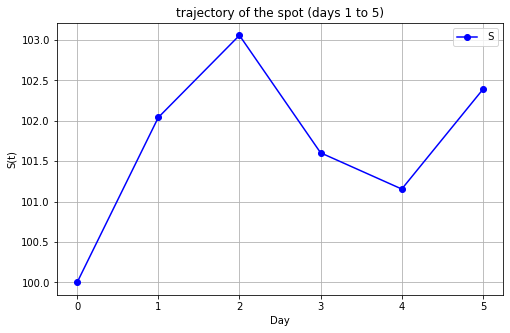

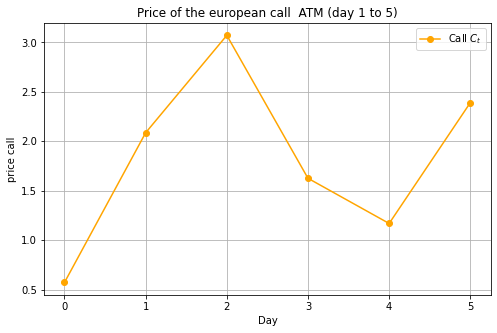

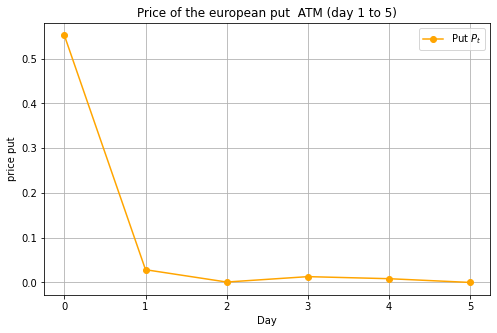

In [8]:
S0 = 100
mu = 0.05
sigma_real = 0.15 # PARAMETER TO SET
T = 1.0
N = 252

r = 0.01
K = S0 
sigma_iv = 0.1 # PARAMETER TO SET


# ----------------- trajectory of St -------------------- #
trajectory = simulate_gbm(S0, mu, sigma_real, T, N)

# Grille de temps
t = np.linspace(0, T, N + 1)

# Graphique
plt.figure(figsize=(10, 5))
plt.plot(t, trajectory, lw=2, color='blue')
plt.title("geomtric brownian motion simulation")
plt.xlabel("Time in year")
plt.ylabel("Spot")
plt.grid(True)
plt.show()

# ---------------- trajectory of St on 5days ----------------- #

jours = np.arange(0, 6)  # Jours 1 à 5
S_values = [trajectory[j] for j in jours]  # Valeurs du sous-jacent sur ces jours

plt.figure(figsize=(8,5))
plt.plot(jours, S_values, marker='o', color='blue', label=" S")
plt.title("trajectory of the spot (days 1 to 5)")
plt.xlabel("Day")
plt.ylabel("S(t)")
plt.grid(True)
plt.legend()
plt.show()

# computation of the realised volatility over the 5 first day
log_returns = np.diff(np.log(trajectory[:6]))  # jours 0 à 5 => 5 retours
realised_vol = np.sqrt(np.mean((log_returns - np.mean(log_returns)) ** 2) * 252)



# ----------------- trajectory of the call ------------------- #
jours = np.arange(0, 6)  
C = []
for j in jours:
    S_t = trajectory[j]                   
    time_to_maturity = (5 - j) / 252    
    C_t = black_scholes_call_price(S_t, K, time_to_maturity, r, sigma_iv)
    C.append(C_t)


plt.figure(figsize=(8,5))
plt.plot(jours, C, marker='o', color='orange', label="Call $C_t$")
plt.title("Price of the european call  ATM (day 1 to 5)")
plt.xlabel("Day")
plt.ylabel("price call")
plt.grid(True)
plt.legend()
plt.show()

# ----------------- trajectory of the put ------------------- #
jours = np.arange(0, 6)  
P = []
for j in jours:
    S_t = trajectory[j]                   
    time_to_maturity = (5 - j) / 252    
    P_t = black_scholes_put_price(S_t, K, time_to_maturity, r, sigma_iv)
    P.append(P_t)


plt.figure(figsize=(8,5))
plt.plot(jours, P, marker='o', color='orange', label="Put $P_t$")
plt.title("Price of the european put  ATM (day 1 to 5)")
plt.xlabel("Day")
plt.ylabel("price put")
plt.grid(True)
plt.legend()
plt.show()


what is gained in the delta hedge portfolio between t1 and t2 :  -0.03438613189852471
delta call  1.513639856767405
delta put  -0.5235715515159098
what we gain in the straddle between t1 and t2 :  0.9900683052514951
what is gained in the delta hedge portfolio between t1 and t2 :  -0.9063310110685452
delta call  0.9847296274695907
delta put  -0.027521864039335875
what we gain in the straddle between t1 and t2 :  0.9572077634302549
what is gained in the delta hedge portfolio between t1 and t2 :  1.4493314450933654
delta call  -1.4452911833750761
delta put  0.012047872471760201
what we gain in the straddle between t1 and t2 :  -1.433243310903316
what is gained in the delta hedge portfolio between t1 and t2 :  0.4197162652822944
delta call  -0.45685288652249767
delta put  -0.004602796695041711
what we gain in the straddle between t1 and t2 :  -0.4614556832175394
what is gained in the delta hedge portfolio between t1 and t2 :  -1.1479552649865716
delta call  1.221632863672923
delta put  -0.

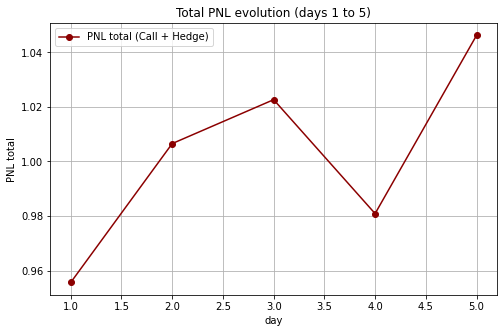

Volatility used for the simulation :  0.15
Realised volatility :  0.19613080566025806
Implied Volatility :  0.1
PNL total =  1.046211602638162


In [9]:
# --- Calculation and plotting of total PNL (Call + replication strategy) ---

jours = np.arange(1, 6)  
dt = 1/252
hedge_gain = []
PNL_total = []
C_0 = black_scholes_call_price(S0, K, 5/252, r, sigma_iv)
P_0 = black_scholes_put_price(S0, K, 5/252, r, sigma_iv)

for j in jours:
    S_tbefore = trajectory[j-1]
    S_t = trajectory[j]
    time_to_maturity_before = (5 - (j-1)) / 252
    time_to_maturity = (5 - j)/ 252

    # Prix du call, put et delta
    C_tbefore = black_scholes_call_price(S_tbefore, K, time_to_maturity_before, r, sigma_iv)
    C_t = black_scholes_call_price(S_t, K, time_to_maturity, r, sigma_iv)

    P_tbefore = black_scholes_put_price(S_tbefore, K, time_to_maturity_before, r, sigma_iv)
    P_t = black_scholes_put_price(S_t, K, time_to_maturity, r, sigma_iv)

    delta_call_t = black_scholes_call_delta(S_tbefore, K, time_to_maturity_before, r, sigma_iv)
    delta_put_t = black_scholes_put_delta(S_tbefore, K, time_to_maturity_before, r, sigma_iv)

    # hedge strat
    # t1 and t2 are two consecutive moments of delta hedging.
    hedge_value = -delta_call_t * (S_t-S_tbefore) + (delta_call_t * S_tbefore - C_tbefore) * (np.exp(r * dt)-1) -delta_put_t*(S_t-S_tbefore) + (delta_put_t * S_tbefore - P_tbefore) * (np.exp(r * dt)-1)
    print("what is gained in the delta hedge portfolio between t1 and t2 : ",hedge_value)
    print("delta call ", C_t - C_tbefore)
    print("delta put ", P_t - P_tbefore)
    print("what we gain in the straddle between t1 and t2 : ", C_t + P_t - C_tbefore - P_tbefore)
    hedge_gain.append(hedge_value)

    # PNL total = Call + Hedge
    pnl_total_t = (C_t + P_t - C_0 - P_0) + np.sum(hedge_gain[:j]) #Serie telescopique
    #print("diff de call : ", C_t-C_tbefore)
    PNL_total.append(pnl_total_t)
    
print(PNL_total)

# ------------ PLOT -------------   
plt.figure(figsize=(8,5))
plt.plot(jours, PNL_total, marker='o', color='darkred', label="PNL total (Call + Hedge)")
plt.title("Total PNL evolution (days 1 to 5)")
plt.xlabel("day")
plt.ylabel("PNL total")
plt.grid(True)
plt.legend()
plt.show()

print("Volatility used for the simulation : ", sigma_real)
print("Realised volatility : ", realised_vol)
print("Implied Volatility : ", sigma_iv)
print("PNL total = ", PNL_total[-1])

In [10]:
st0 = 80
st1 = st0 * np.exp(0.09/np.sqrt(252))

In [11]:
iv = 8
st0 = 100
st1 = st0 * np.exp(0.0/np.sqrt(252))

c0 = black_scholes_call_price(st0, K, 5/252, r, iv)
c1 = black_scholes_call_price(st1, K, 4/252, r, iv)
ddc = black_scholes_call_delta(st0, K, 5/252, r, iv)

p0 = black_scholes_put_price(st0, K, 5/252, r, iv)
p1 = black_scholes_put_price(st1, K, 4/252, r, iv)
ddp = black_scholes_put_delta(st0, K, 5/252, r, iv)

deltag = -ddc * (st1-st0) + (ddc * st0 - c0) * (np.exp(r * dt)-1) -ddp*(st1-st0) + (ddp * st0 - p0) * (np.exp(r * dt)-1)
print(deltag + c1+p1 -c0-p0)



-8.23069686113012


In [12]:
black_scholes_call_price(95, K, 5/252, r, sigma_iv)

4.801503143006709e-05

# Part 3 : Monte-Carlo simulation of gamma scalping for a long **straddle**


We now simulate multiple spot price paths using the same simulation volatility. For each path, we perform a gamma scalping strategy and then aggregate the results by taking the average PnL across all paths.

In [13]:
def monte_carlo_gamma_scalping(S0, mu, sigma_real, sigma_iv, r, K, T, N, n_simulations):
    """ 
    Monte-carlo simulation of gamma scalping for a given sigma simulation, sigma implied, for option of maturity 5 days
    """
    dt = 1 / N
    jours = np.arange(1, 6)
    PNL_totals = []
    all_trajectories = []
    realised_vols = []

    for sim in range(n_simulations):
        trajectory = simulate_gbm(S0, mu, sigma_real, T, N)
        all_trajectories.append(trajectory[:6]) 

        # CALCULATION OF THE REALISED VOLATILITY
        log_returns = np.diff(np.log(trajectory[:6]))  # 5 returns
        realised_vol = np.sqrt(np.mean((log_returns) ** 2) * 252)
        realised_vols.append(realised_vol)
        
        hedge_gain = []
        PNL_total = []
        C_0 = black_scholes_call_price(S0, K, 5 / 252, r, sigma_iv)
        P_0 = black_scholes_put_price(S0, K, 5 / 252, r, sigma_iv)

        # ----- GAMMA SCALPING -------
        for j in jours:
            S_tbefore = trajectory[j - 1]
            S_t = trajectory[j]
            time_to_maturity_before = (5 - (j - 1)) / 252
            time_to_maturity = (5 - j) / 252

            C_tbefore = black_scholes_call_price(S_tbefore, K, time_to_maturity_before, r, sigma_iv)
            C_t = black_scholes_call_price(S_t, K, time_to_maturity, r, sigma_iv)
            P_tbefore = black_scholes_put_price(S_tbefore, K, time_to_maturity_before, r, sigma_iv)
            P_t = black_scholes_put_price(S_t, K, time_to_maturity, r, sigma_iv)

            delta_call_t = black_scholes_call_delta(S_tbefore, K, time_to_maturity_before, r, sigma_iv)
            delta_put_t = black_scholes_put_delta(S_tbefore, K, time_to_maturity_before, r, sigma_iv)

            hedge_value = (-delta_call_t * (S_t - S_tbefore) +
                           (delta_call_t * S_tbefore - C_tbefore) * (np.exp(r * dt) - 1)
                         - delta_put_t * (S_t - S_tbefore) +
                           (delta_put_t * S_tbefore - P_tbefore) * (np.exp(r * dt) - 1))
            
            hedge_gain.append(hedge_value)

            pnl_total_t = (C_t + P_t - C_0 - P_0) + np.sum(hedge_gain[:j])
            PNL_total.append(pnl_total_t)
        # ---------------------------
        
        PNL_totals.append(PNL_total[-1])  
    

    # --- Trajectories of the spot ---
    plt.figure(figsize=(10, 5))
    for traj in all_trajectories:
        plt.plot(np.arange(6), traj, alpha=0.5)
    plt.title("Trajectoires du spot (jours 0 à 5)")
    plt.xlabel("Jour")
    plt.ylabel("Spot")
    plt.grid(True)
    plt.show()

    # --- PNL ---
    plt.figure(figsize=(8, 4))
    plt.hist(PNL_totals, bins=20, color="steelblue", edgecolor="black")
    plt.axvline(np.mean(PNL_totals), color='red', linestyle='--', label=f"Mean PnL = {np.mean(PNL_totals):.4f}")
    plt.title("Distribution des PnL finaux (j=5)")
    plt.xlabel("PnL final")
    plt.ylabel("Fréquence")
    plt.grid(True)
    plt.legend()
    plt.show()

    # AVERAGE REALISED VOLATILITY
    mean_realised_vol = np.mean(realised_vols)

    print("Volatility used for the simulation : ", sigma_real)
    print("Average Realised volatility : ", mean_realised_vol)
    print("Implied Volatility : ", sigma_iv)

    return np.mean(PNL_totals)


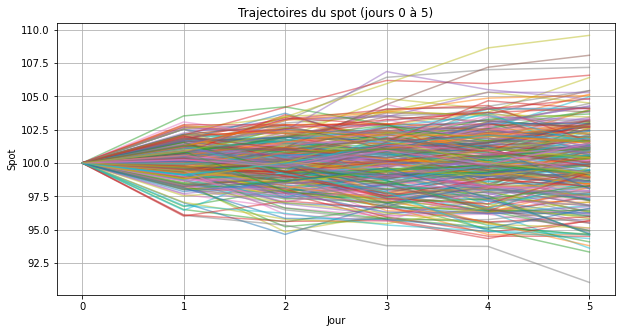

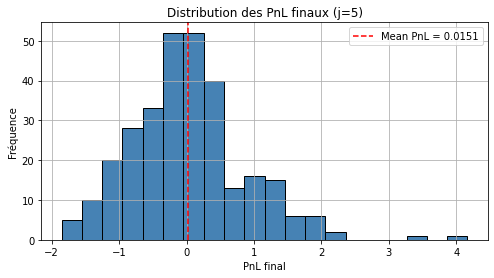

Volatility used for the simulation :  0.2
Average Realised volatility :  0.19089193651203057
Implied Volatility :  0.2
CASE : Realized Volatility = Implied Volatility
Average PnL : 0.015118293215244065


In [17]:
mean_pnl = monte_carlo_gamma_scalping(
    S0=100,
    mu=0.05,
    sigma_real=0.2,    # PARAMETER TO SET
    sigma_iv=0.2,      # PARAMETER TO SET
    r=0.0,
    K=100,
    T=1.0,
    N=252,
    n_simulations=300
)

print("CASE : Realized Volatility = Implied Volatility")
print("Average PnL :", mean_pnl)


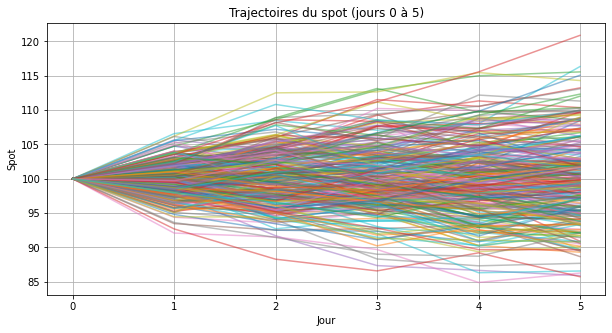

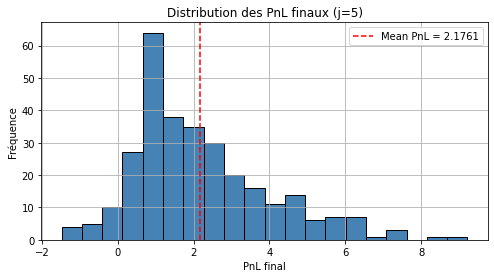

Volatility used for the simulation :  0.4
Average Realised volatility :  0.3933186566681404
Implied Volatility :  0.2
CASE : Realized Volatility > Implied Volatility
Average PnL : 2.176143841185173


In [18]:
mean_pnl = monte_carlo_gamma_scalping(
    S0=100,
    mu=0.05,
    sigma_real=0.4,    # PARAMETER TO SET
    sigma_iv=0.2,      # PARAMETER TO SET
    r=0.0,
    K=100,
    T=1.0,
    N=252,
    n_simulations=300
)

print("CASE : Realized Volatility > Implied Volatility")
print("Average PnL :", mean_pnl)

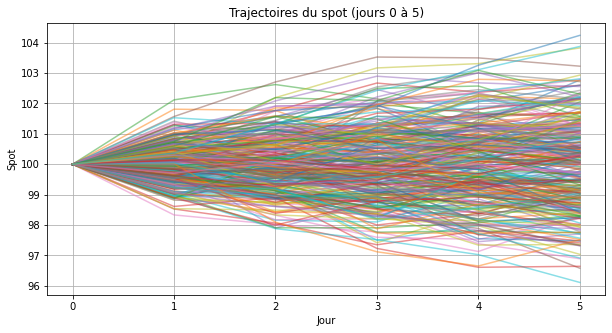

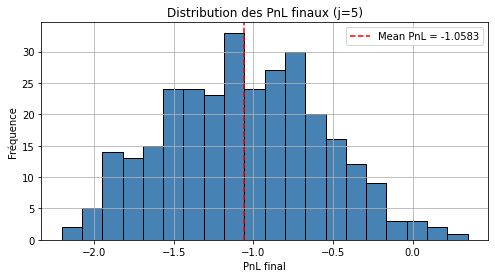

Volatility used for the simulation :  0.1
Average Realised volatility :  0.09710786337013275
Implied Volatility :  0.2
CASE : Realized Volatility < Implied Volatility
Average PnL : -1.0582774475143237


In [19]:
mean_pnl = monte_carlo_gamma_scalping(
    S0=100,
    mu=0.05,
    sigma_real=0.1,    # PARAMETER TO SET
    sigma_iv=0.2,      # PARAMETER TO SET
    r=0.0,
    K=100,
    T=1.0,
    N=252,
    n_simulations=300
)

print("CASE : Realized Volatility < Implied Volatility")
print("Average PnL :", mean_pnl)